## 순환 신경망 제작, 텍스트 분류 

In [27]:
# 데이터셋 불러오기 
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb # 인터넷 영화 데이터베이스(Internet Movie Database, 영화 리뷰 데이터). 

# 리뷰가 긍정적인지 부정적인지 판단하는 모델을 만들 것

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100) # imdb 데이터셋은 리뷰에 포함된 8만개 이상의 단어를 고유한 정수로 미리 바꿔놓음
# skip_top : 가장 많이 등장한 단어들 중 건너뛸 단어의 개수를 지정. 예를 들면 a, the, is같은 애들. 얘들은 많이 나오는데 분석에는 유용한 애들이 아니니 건너뛴다. 
# num_words : 훈련에 사용될 단어의 개수. 


In [28]:
print(x_train_all.shape, y_train_all.shape) # 크기 확인

(25000,) (25000,)


In [29]:
# 샘플 확인
print(x_train_all[0]) # 숫자만 존나게 나옴. 이 정수들은 영단어를 고유한 정수에 일대일 대응한 것. 이를 BoW(Bag of Word) 혹은 어휘 사전이라 부름. 
# 2는 어휘사전에 없는 단어를 의미함. 왜 2만 존나게 떴냐면 앞서 데이터를 불러올 때 가장 많이 등장하는 영단어를 20개나 스킵한데다 훈련에 사용할 단어도 100개 뿐이기 때문. 그래서 사전에 없는 영단어가 많다. 

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [30]:
# 쓸모없는 단어 지우기 
# 0과 1은 패딩이고 2는 어휘사전에 없는 단어(=훈련에 쓰지 않는 단어)를 의미하기 때문에 지워준다. 
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

In [7]:
print(x_train_all[0]) # 의미 있는 단어들만 등장. 추측상 단어에 해당하는 번호들의 모음이 아닐까 싶다. 인덱스 번호 뭐 그런거겠지

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [31]:
# 어휘 사전 내려받기
# 훈련 세트를 영단어로 바꿔보자. 
word_to_index = imdb.get_word_index()
word_to_index['movie'] # movie에 해당하는 키 값을 출력 -> 17이라고 나옴

17

In [32]:
# 훈련 세트의 정수를 영단어로 변환 
# 훈련 세트에 있는 정수는 3 이상부터 영단어를 의미한다.(0, 1은 패딩이고 2는 사용하지 않는 단어) 그래서 3을 뺀 값을 인덱스로 써야한다. 
index_to_word = {word_to_index[k] : k for k in word_to_index} # 일반적인 문자열 배열로 바꿔주는 듯. 

for w in x_train_all[0]:
    print(index_to_word[w-3], end=' ') # 단어들 출력

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [33]:
# 훈련 샘플의 길이 확인
print(len(x_train_all[0]), len(x_train_all[1])) # 샘플의 길이가 차이가 어느정도 있다. 이러면 훈련 시키기가 어렵다. 

59 32


In [34]:
# 타깃 데이터 확인
# 리뷰가 긍정인지 부정인지 확인하는 모델이니 긍정, 부정의 이진 분류 문제를 다룬다고 볼 수 있다. 그래서 타깃 데이터의 값들은 0 아니면 1이다. 
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [36]:
# 검증 세트 준비
# 훈련 데이터셋 중 일부만 떼서 검증 셋으로 활용 
np.random.seed(42) # 교재랑 같은 값이 나온다는거 확인시켜줄려고 랜덤 상수 고정
random_index = np.random.permutation(25000) # 데이터 섞어주기. '단어들의 모음'을 섞으니 문제 없다. 

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [37]:
# 데이터 길이 맞추기
# 일정 길이를 정해놓고 길면 왼쪽을 짜르고(0~) 짧으면 왼쪽을 0으로 채운다. 만약 오른쪽으로 0으로 채운다면 순환 레이어의 역방향 계산 특성상 이전 연산의 출력값을 꼬리를 무는 방식으로 사용하기 때문에 좋은 성능을 기대하기 힘들 것이다.(꼬리를 물다가 미자막에 0이 나오는 방식이 더 낫다)

# 텐서플로우로 샘플의 길이 맞추기 
from tensorflow.keras.preprocessing import sequence

maxlen = 100 # 샘플 길이를 100으로 맞춤
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen) # 100보다 작으면 채우고 길면 자르고
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [16]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [17]:
print(x_train_seq[0]) # 부족한 크기만큼 왼쪽에 0으로 채웠다. 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [38]:
# 모델 훈련을 위해 데이터 전처리 -> 정수 데이터(입력 데이터)를 원-핫 인코딩. 생각해보니 데이터 전처리는 입력 데이터만 하면 되는구나. 허허...
from tensorflow.keras.utils import to_categorical

# 길이 맞춰놓은 애들 원-핫 인코딩 처리
x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)


In [19]:
print(x_train_onehot.shape) # 크기 확인

(20000, 100, 100)


In [20]:
print(x_train_onehot.nbytes) # 용량 확인. 800000000 -> 800 * 1,000,000 => 약 760MB라고 한다. 왜 760MB지? 진수가 달라서 그런가

800000000


In [46]:
# 모델 클래스 작성 

class RecurrentNetwork:
    def __init__(self, n_cells = 10, batch_size = 32, learning_rate = 0.1):

        self.n_cells = n_cells # 셀 개수(유닛 개수라 생각하면 된다. 실제로 같은 의미를 가진다.)
        self.batch_size = batch_size

        self.w1h = None # 은닉 상태에 대한 가중치(=이전 연산의 출력값에 대한 가중치)
        self.w1x = None # 입력에 대한 가중치
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.h = None # 순환층의 활성화 출력
        self.losses = [] # 훈련 손실
        self.val_losses = [] # 검증 손실
        self.lr = learning_rate # 학습률

    def init_weights(self, n_features, n_classes): # 순환 레이어의 가중치들은 직교 행렬 방식으로 초기화. 직교 행렬 초기화 방식은 순환 셀에서 은닉 상태를 위한 가중치가 반복해서 곱해질 때 너무 커지거나 작아지지 않도록 만들어준다. 
        orth_init = tf.initializers.Orthogonal() # Orthogonal()제공
        glolot_init = tf.initializers.GlorotUniform()

        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy() # (셀 개수, 셀 개수) 
        self.w1x = glolot_init((n_features, self.n_cells)).numpy() # (특성 개수, 셀 개수)
        self.b1 = np.zeros(self.n_cells) # 은닉층의 크기
        self.w2 = glolot_init((self.n_cells, n_classes)).numpy() # (셀 개수, 클래스 개수)
        self.b2 = np.zeros(n_classes)

    def forpass(self, x):# 정방향 계산
        self.h = [np.zeros((x.shape[0], self.n_cells))] # 은닉 상태 초기화
        seq = np.swapaxes(x, 0, 1) # 입력 x의 첫 번째 배치 차원과 두 번째 타임 스탭 차원을 변경. 왜 이걸 하는걸까?
        # 왜 이걸 하냐면 원래 데이터셋은 (샘플, 타임스탭, 원-핫-인코딩)이라 그대로 정방향 계산을 할 경우 한 샘플의 모든 타임스텝을 한 번에 계산해버린다. 
        # 허나 이는 우리가 원하는 방식이 아니다. 우리는 한 타임스탭씩 계산하길 원한다. 그래서 '모든 샘플'을 타임 스탭 단위로 연산하기 위해 (타임스탭, 샘플, 원-핫-인코딩)으로 바꾼 것이다. 
        # 바꾼 이후 정방향 계산
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1 # 순환 레이어 선형계산
            h = np.tanh(z1)
            self.h.append(h)
            z2 = np.dot(h, self.w2) + self.b2 # 완전 연결 레이어 선형계산
        return z2
    
    def backprop(self, x, err): # 역방향 계산. 역방향 계산 역시 타임스탭과 미니 배치의 차원을 맞바꿈.
        m = len(x) # 입력 데이터 개수
        
        # 출력층의 가중치, 절편에 대한 공식
        w2_grad = np.dot(self.h[-1].T, err) / m # 완전 연결층에서 그레디언트
        b2_grad = np.sum(err)/ m # 절편에 대한 그래디언트
        # 배치 차원과 타임 스태프 차원을 맞바꿈
        seq = np.swapaxes(x, 0, 1)
        
        # 첫번 째 층의 그래디언트
        w1h_grad = w1x_grad = b1_grad = 0
        # 이론에서 배웠듯 순환 레이어 직전까지 그레디언트를 계산하고 err_to_cell이라고 정의
        err_to_cell = np.dot(err, self.w2.T) * (1-self.h[-1] ** 2)
        ## 맨 처음 출력값까지 거슬러 올라가며 그레디언트 전파
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]): # -1을 넣었다 -> 뒤에서부터 앞으로 돌리겠다. 식보면 알겠지만 최근 값(제일 뒤에 있는 값)에서 시작해 가장 옛날 값(제일 앞에 있는 값)까지 가기 때문에 이렇게 역으로 돌려야한다. 
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            # 이전 타임 스텝의 셀 직전까지 다시 그레디언트 계산(꼬리의 꼬리를 물기)
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1-h ** 2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m

        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self, z): # 시그모이드 활성화 함수
        a = 1/(1+np.exp(-z))
        return a

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        y = y.reshape(-1, 1) # 타깃을 열 벡터(위아래로 긴거)로 바꿈
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42) # 교재에서 예제와 같음을 보여주기 위해 사용한 함수. 실제로는 사용하지 않아도 된다. 
        self.init_weights(x.shape[2], y.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        
        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 미니 배치를 순환하는 for문
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y): # gen_batch() : 전체 데이터를 받아 batch_size의 크기를 갖는 미니 배치를 만들어 반환
                print('.', end='')
                a = self.training(x_batch, y_batch) # 미니 배치 단위로 정방향, 역방향 계산을 수행. 출력값으로 마지막 활성화 함수의 출력을 반환
               
                a = np.clip(a, 1e-10, 1-1e-10) # 클리핑. 이렇게 해야 활성화 값이 튀겨서 계산에 지장이 생기는 일을 방지할 수 있다. 
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a))) # 각 미니배치마다 발생하는 log손실과 규제 손실(reg_loss)을 차곡차곡 쌓음.
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니 배치가 몇개 있는가? (//연산자는 '몫'을 의미)
        if length % self.batch_size : # 몫으로 나누고 나머지 값이 있으면 
            bins +=1 # 1 추가. 왜냐하면 배치사이즈로 데이터 나누고 남은 값을 버릴 수는 없으니
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞음. x길이만큼 생성된 [0, 1, 2, ...] 배열을 셔플한 걸 반환
        #이 코드를 왜 쓰는거지? ======
        x = x[indexes] # 이렇게 하면 x, y가 섞이나보다. 
        y = y[indexes]
        #이 코드를 왜 쓰는거지? ======
        for i in range(bins):
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end] # yield : 반환 방식. 큰 데이터를 한 번만 반환함. 이게 뭔 뜻이냐면 전체 데이터셋 중 index의 범위가 start~end에 해당하는 배열의 일부분을 반환한다는 뜻이다. 이 때 start~end의 범위는 batch_size의 크기와 같다. 매번 포문을 진행할 때마다 batch_size크기에 해당하는 미니 배치들을 처음 데이터부터 마지막 데이터까지 순서대로 뽑아내서 반환하고 이를 이용해 훈련을 시킨다는 거다.
    
    def training(self, x, y):
        m=len(x)
        z = self.forpass(x) # 출력
        a = self.sigmoid(z) # 활성화 함수
        err = -(y-a) # 오차

        #역전파로 그래디언트 계산
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 가중치, 절편 업데이트
        #셀의 가중치, 절편 업데이트
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치, 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self,x): # 예측
        z = self.forpass(x)
        return z>0
    
    def score(self, x, y): # 성능 확인
        # 예측값, 타깃 값 비교해 True의 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1,1))

    def update_val_loss(self, x_val, y_val): # 검증 세트의 손실 업데이트
        z = self.forpass(x_val) # 정방향 계산
        a = self.sigmoid(z) # 활성화 함수
        a = np.clip(a, 1e-10, 1-1e-10) # 활성화 함수 클리핑
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.losses.append(val_loss)



In [47]:
rn = RecurrentNetwork(n_cells=32, batch_size = 32, learning_rate = 0.01) 

In [48]:
rn.fit(x_train_onehot, y_train, epochs = 20, x_val = x_val_onehot, y_val = y_val) # 타임 스텝 횟수는 모두 하이퍼 파라미터(내가 설정하는 값)이다. 그러니 반복적으로 훈련 시키며 적절한 값을 찾아야한다. 

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

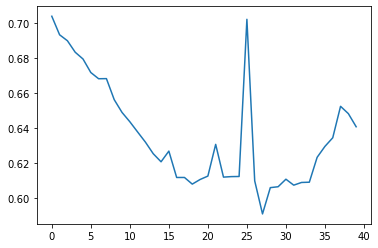

In [49]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show() #뭐지 왜 하나만 뜨지. 아무튼 그래프가 좀 들쭉날쭉하지만 손실이 잘 감소되고 있음을 알 수 있다.

In [50]:
# 정확도 평가
rn.score(x_val_onehot, y_val) # 약 64%다. 영화의 리뷰가 긍정인지 부정인지 맞출 확률이 64%라는 뜻. 텐서플로를 이용하면 더 정확도를 높일 수 있을거 같다. 

0.6432

In [ ]:
# 입력 데이터셋으로 문자열을 저장할거란 생각은 하지 않았다. 역시 그랬다. 사전의 인덱스값들을 저장해놓고 사전 파일을 따로 만들었구나. 
# 이걸 원-핫 인코딩으로 만드는건 예외였다. 생각해보니 행렬 연산 하는걸 생각하면 원-핫 인코딩으로 행렬 연산이 요구하는 입력값에 맞추는게 맞구나. 그래야하네. 아하. 
# 선형대수학 복습해야겠다. 뭔 계산할 때마다 행렬 연산으로 머리 잡고 있냐. 흑흑.